<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter08/Training_SSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working details of SSD
different layers have different receptive fields to the original image. For example, the initial layers have a smaller receptive field when compared to the final layers, which have a larger receptive field.  
SSD leverages this phenomenon to come up with a prediction of bounding boxes for images.  

The workings behind how SSD helps overcome the issue of detecting objects with different scales is as follows:
- We leverage the pre-trained VGG network and extend it with a few additional layers until we obtain a 1 x 1 block.
- Instead of leveraging only the final layer for bounding box and class predictions, we will leverage all of the last few layers to make class and bounding box predictions.
- In place of anchor boxes, we will come up with default boxes that have a specific set of scale and aspect ratios.
- Each of the default boxes should predict the object and bounding box offset just like how anchor boxes are expected to predict classes and offsets in YOLO.

## Network Architecture
The network architecture is as follows:
![ssd_arch](ssd_1.png)
we are taking an image of size 300 x 300 x 3 and passing it through a pre-trained VGG-16 network to obtain the `conv5_3` layer's output. Furthermore, we are extending the network by adding a few more convolutions to the `conv5_3` output.  

we obtain a bounding box offset and class prediction for each cell and each default box (more on default boxes in the next section; for now, let's imagine that this is similar to an anchor box). The total number of predictions coming from the `conv5_3` output is 38 x 38 x 4, where 38 x 38 is the output shape of the `conv5_3` layer and 4 is the number of default boxes operating on the `conv5_3` layer 

The total number of parameters across the network is as follows:


Note that certain layers have a larger number of boxes (6 and not 4) when compared to other layers in the architecture described in the original paper  
### Scales of default boxes

Let's imagine a scenario where the minimum scale of an object is 20% of the height and 20% of the width of an image, and the maximum scale of the object is 90% of the height and 90% of the width. In such a scenario, we gradually increase scale across layers (as we proceed toward later layers, the image size shrinks considerably), as follows:
![ssd_params](ssd_2.png)

The formula that enables the gradual scaling of the image is as follows:
![ssd_3](ssd_3.png)

### aspect ratios of default boxes
The possible aspect ratios are as follows:
![ssd_4](ssd_4.png)

The center of the box for layer l is: 
![ssd_5](ssd_5.png)

the width and height corresponding to aspect ratio r are:
![ssd_6](ssd_6.png)

so far we've seen that we have 5 different aspect ratios. in the implementation we either have 4 or 6 boxes in a layer. to get to 4, we remove the 3 and 1/3 aspect ratio boxes . so we have either 5 or 3, right ? where's the last box ? we add another scale for the 6th (or 4th) box as follows:
![ssd_7](ssd_7.png)


## Preparing the dataset
The default boxes that have an IoU greater than a threshold (say, 0.5) are considered positive matches, and the rest are negative matches.  
In the output of SSD, we predict the probability of the box belonging to a class (where the 0th class represents the background) and also the offset of the ground truth with respect to the default box.


## Loss values
we train the model by optimizing the following loss values:  

**Classification loss**: 
![ssd_8](ssd_8.png)
`pos` represents the few default boxes that have a high overlap with the ground truth, while `neg` represents the misclassified boxes that were predicting a class but in fact did not contain an object. Finally, we ensure that the `pos:neg` ratio is at most 1:3, as if we do not perform this sampling, we would have a dominance of background class boxes.

**Localization Loss**:
we consider the loss values only when the objectness score is greater than a certain threshold. The localization loss is calculated as follows:
![ssd_9](ssd_9.png)

t is the predicted offset and d is the actual offset

In [1]:
import os
# if not os.path.exists('open-images-bus-trucks'):
#     !pip install -q torch_snippets
#     !wget --quiet https://www.dropbox.com/s/agmzwk95v96ihic/open-images-bus-trucks.tar.xz
#     !tar -xf open-images-bus-trucks.tar.xz
#     !rm open-images-bus-trucks.tar.xz
#     !git clone https://github.com/sizhky/ssd-utils/
%cd ssd-utils

/home/guy/workspace/study/git/guyk1971/Modern-Computer-Vision-with-PyTorch/Ch08_Adv_Obj_Det/ssd-utils


In [2]:
from torch_snippets import *
DATA_ROOT = '/home/guy/datasets/open-images-bus-trucks/ch08/'
IMAGE_ROOT = f'{DATA_ROOT}/images'
DF_RAW = df = pd.read_csv(f'{DATA_ROOT}/df.csv')

df = df[df['ImageID'].isin(df['ImageID'].unique().tolist())]

label2target = {l:t+1 for t,l in enumerate(DF_RAW['LabelName'].unique())}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
import collections, os, torch
from PIL import Image
from torchvision import transforms
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
denormalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()
    
class OpenDataset(torch.utils.data.Dataset):
    w, h = 300, 300
    def __init__(self, df, image_dir=IMAGE_ROOT):
        self.image_dir = image_dir
#         self.files = glob.glob(self.image_dir+'/*')
        self.files = Glob(self.image_dir+'/*')
        self.df = df
        self.image_infos = df.ImageID.unique()
        logger.info(f'{len(self)} items loaded')
        
    def __getitem__(self, ix):
        # load images and masks
        image_id = self.image_infos[ix]
        img_path = find(image_id, self.files)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.
        data = df[df['ImageID'] == image_id]
        labels = data['LabelName'].values.tolist()
        data = data[['XMin','YMin','XMax','YMax']].values
        data[:,[0,2]] *= self.w
        data[:,[1,3]] *= self.h
        boxes = data.astype(np.uint32).tolist() # convert to absolute coordinates
        return img, boxes, labels

    def collate_fn(self, batch):
        images, boxes, labels = [], [], []
        for item in batch:
            img, image_boxes, image_labels = item
            img = preprocess_image(img)[None]
            images.append(img)
            boxes.append(torch.tensor(image_boxes).float().to(device)/300.)
            labels.append(torch.tensor([label2target[c] for c in image_labels]).long().to(device))
        images = torch.cat(images).to(device)
        return images, boxes, labels
    def __len__(self):
        return len(self.image_infos)

In [6]:
from sklearn.model_selection import train_test_split
trn_ids, val_ids = train_test_split(df.ImageID.unique(), test_size=0.1, random_state=99)
trn_df, val_df = df[df['ImageID'].isin(trn_ids)], df[df['ImageID'].isin(val_ids)]
len(trn_df), len(val_df)

train_ds = OpenDataset(trn_df)
test_ds = OpenDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn, drop_last=True)

2022-04-17 12:46:28.197 | INFO     | __main__:__init__:26 - 13702 items loaded
2022-04-17 12:46:28.273 | INFO     | __main__:__init__:26 - 1523 items loaded


In [7]:
def train_batch(inputs, model, criterion, optimizer):
    model.train()
    N = len(train_loader)
    images, boxes, labels = inputs
    _regr, _clss = model(images)
    loss = criterion(_regr, _clss, boxes, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss
    
@torch.no_grad()
def validate_batch(inputs, model, criterion):
    model.eval()
    images, boxes, labels = inputs
    _regr, _clss = model(images)
    loss = criterion(_regr, _clss, boxes, labels)
    return loss

In [8]:
from model import SSD300, MultiBoxLoss
from detect import *

In [9]:
n_epochs = 3

model = SSD300(num_classes, device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy, device=device)

log = Report(n_epochs=n_epochs)
logs_to_print = 5


Loaded base model.



/home/guy/anaconda3/envs/ptvit/lib/python3.8/site-packages/torch-1.10.1-py3.8-linux-x86_64.egg/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [10]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss = train_batch(inputs, model, criterion, optimizer)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss = validate_batch(inputs, model, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), end='\r')

EPOCH: 3.000	val_loss: 1.934	(2707.97s - 0.00s remaining)))))

In [11]:
image_paths = Glob(f'{DATA_ROOT}/images/*')
image_id = choose(test_ds.image_infos)
img_path = find(image_id, test_ds.files)
original_image = Image.open(img_path, mode='r')
original_image = original_image.convert('RGB')

[[194, 77, 255, 126]] ['Bus @ 0.92']


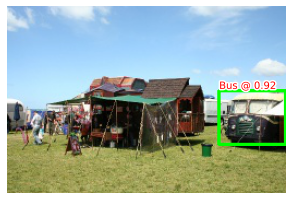

[[105, 28, 209, 98]] ['Bus @ 1.00']


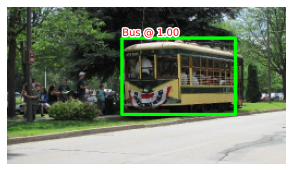

[[3, 20, 241, 140]] ['Truck @ 0.99']


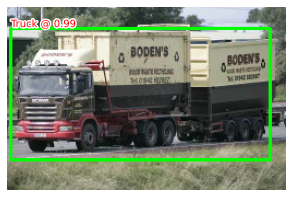

In [12]:
image_paths = Glob(f'{DATA_ROOT}/images/*')
for _ in range(3):
    image_id = choose(test_ds.image_infos)
    img_path = find(image_id, test_ds.files)
    original_image = Image.open(img_path, mode='r')
    bbs, labels, scores = detect(original_image, model, min_score=0.9, max_overlap=0.5,top_k=200, device=device)
    labels = [target2label[c.item()] for c in labels]
    label_with_conf = [f'{l} @ {s:.2f}' for l,s in zip(labels,scores)]
    print(bbs, label_with_conf)
    show(original_image, bbs=bbs, texts=label_with_conf, text_sz=10)
